In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from PIL import Image
from IPython.display import display
import textdistance

from data_preprocess import preprocessing

In [54]:
class SEARCH_RECOMMEND:
    
    def __init__(self, df, qval=None):
        self.df = df
        self.qval = qval
        self.df_ = self.preprocess_df(self.df)
    
    def preprocess_df(self, df):
        # make new-tag
        df['new_tag'] = list(
        zip(
            df['top3_style'].tolist(), 
            df['tags'].tolist(),
            df['name'].tolist(),
            df['projectId'].tolist()
            )
        )

        df['new_tag'] = df['new_tag'].apply(self.reduce_newtag)
        df['new_tag'] = df['new_tag'].apply(lambda x: ' '.join(x).lower())
        return df
    
    def reduce_newtag(self, x):
        newtag = []
        for tag in x:
            if type(tag) == str:
                newtag.append(tag)
            else:
                newtag.extend(tag)
        return newtag

    def search_product(self, prod, topn=10, algo='sorensen'):
        
        # declare id of searching product
        id_ = self.df_[self.df_['name'] == prod]['product_id'].values[0]
        print(f"검색 아이템이 해당한 프로젝트 ID : {self.df_[self.df_['name'] == prod]['projectId'].values[0]}")
        
        # search product tag from input product name
        search_prod_tag = self.df_[self.df_['name'] == prod].sort_values(by='awesome_score', ascending=False)['new_tag'].values[0]

        # calculate similarity
        sim_score = []
        import time
        new_tag = self.df_['new_tag'].tolist()
        start_time = time.time()
        for i, tag in enumerate(new_tag):
            if algo == 'sorensen':
                sim_score.append(textdistance.Sorensen(qval=self.qval, as_set=True).normalized_similarity(search_prod_tag, tag))
            elif algo == 'ncd':
                sim_score.append(textdistance.EntropyNCD(qval=self.qval).normalized_similarity(search_prod_tag, tag))
                

        print(f'검색 태그 : {search_prod_tag}')
        print(f'검색 시간 : {round(time.time()-start_time, 4)}초')
        print()

        # save result
        sim_score = np.asarray(sim_score)
        sim_score_idx = np.arange(len(sim_score))

        result_df = self.df_.iloc[sim_score_idx][['product_id', 'name', 'new_tag', 'projectId', 'images']]
        result_df['similarity'] = sim_score
        result_df = result_df[result_df['product_id']!=id_]
        result_df = result_df.drop_duplicates(['product_id'])
        result_df = result_df.sort_values(by='similarity', ascending=False).reset_index()[:topn]
        
        # show result image
        print(f'사용자가 선택한 아이템 : {prod}')
        try:
            prod_res = requests.get(self.df_[self.df_['name'] == prod]['images'].values[0][0])
            display(Image.open(BytesIO(prod_res.content)))
        except:
            print('이미지 없음\n')
            print()

        print("="*80)
        print(f"추천 아이템 Top{topn}")
        print("="*80)
        
        i = 1
        for name, img_url in result_df[['name', 'images']].values:
            print(f"추천 {i}순위 : {name}")
            try:
                res = requests.get(img_url[0])
                img = Image.open(BytesIO(res.content))
                display(img)
            except:
                print('이미지 없음\n')
            print("-"*60)
            i += 10

        self.result = result_df

In [20]:
base_path = '2022-03-07/'
file_paths = [
    base_path + 'bestshots.json', 
    base_path + 'items.json', 
    base_path +'categories.json', 
    base_path +'products.json'
]

In [21]:
products_df_4, products_df_b = preprocessing(file_paths)
products_df_4.shape, products_df_b.shape

/Users/ruo/Desktop/codestates/CP2/data_preprocess.py:37: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  items_stack = pd.DataFrame(templates_df['items'].apply(lambda x: pd.Series(x)).stack()).reset_index(1, drop=True)


((4211, 10), (46576, 10))

In [57]:
# qval=None => 아이템과 유사한 카테고리의 결과 추천 / qval=int => 아이템과 비슷한 스타일의 다른 아이템 추천(기존 전문가 셋을 기반)
search_engine_b = SEARCH_RECOMMEND(products_df_b, qval=None)

검색 아이템이 해당한 프로젝트 ID : X9djPepD57A2BDCD418437C
검색 태그 : natural mid_century_modern modern 커튼 데코뷰 화이트 쉬폰 화이트 쉬폰 커튼 화이트 x9djpepd57a2bdcd418437c
검색 시간 : 0.5666초

사용자가 선택한 아이템 : 화이트 쉬폰 커튼 화이트


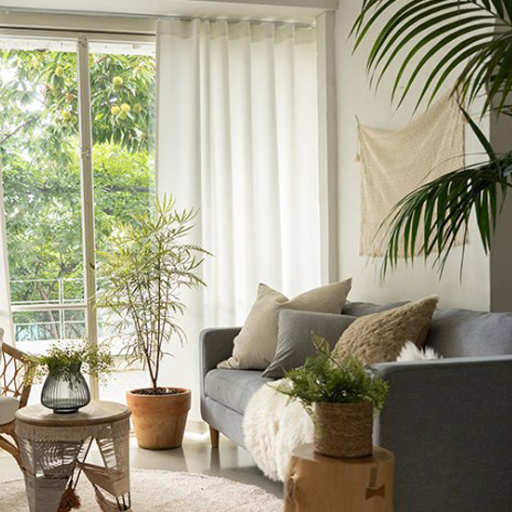

추천 아이템 Top10
추천 1순위 : NEW 린넨스타일 암막커튼 (아이보리)


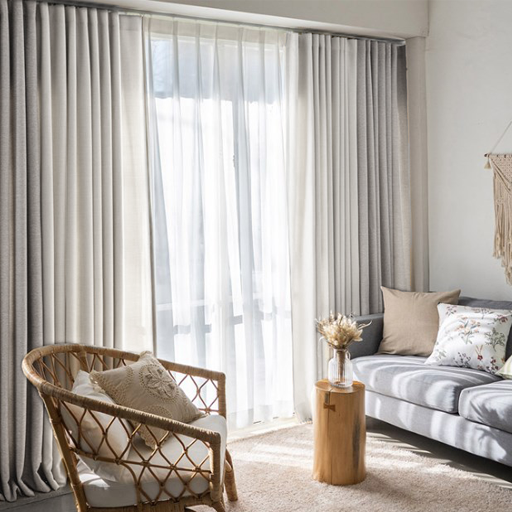

------------------------------------------------------------
추천 11순위 : 드레시 화이트 쉬폰+암막커튼 세트 화이트


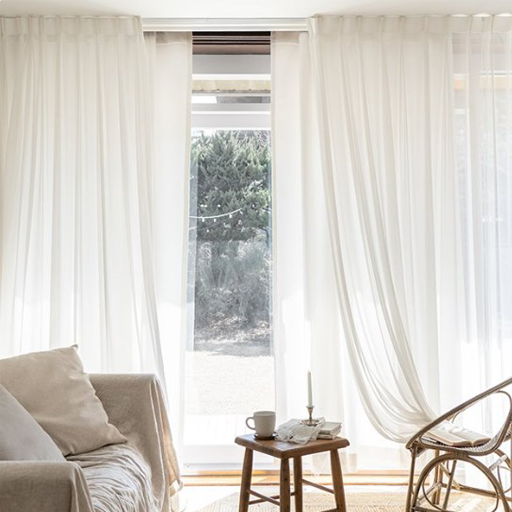

------------------------------------------------------------
추천 21순위 : 호텔식 화이트 시폰 커튼


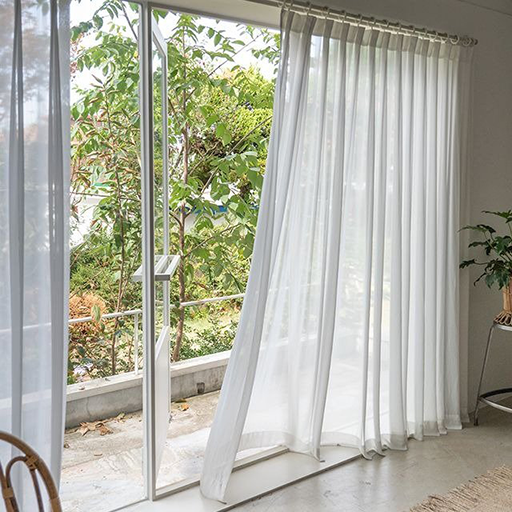

------------------------------------------------------------
추천 31순위 : 시몬 커튼 (묶임) (화이트)


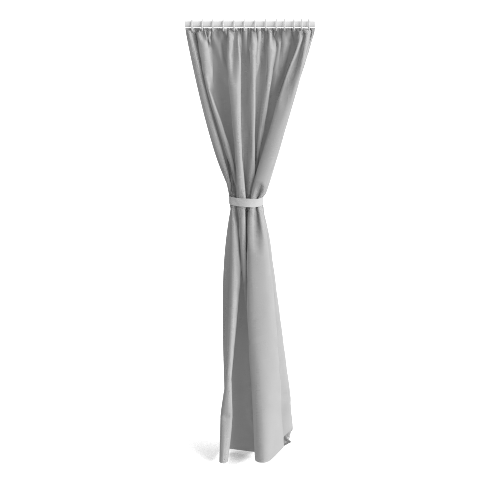

------------------------------------------------------------
추천 41순위 : 블랙 쉬폰 나비주름 커튼


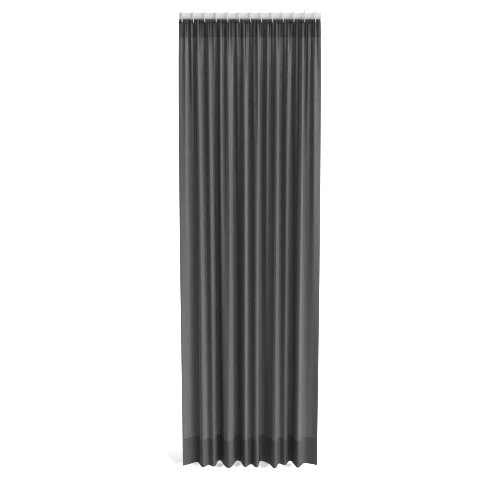

------------------------------------------------------------
추천 51순위 : 화이트 워싱 광목커튼


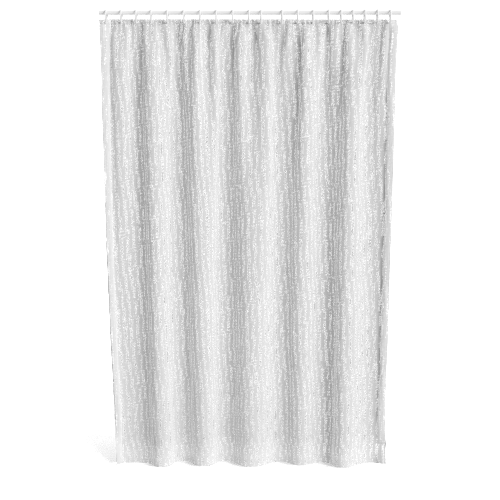

------------------------------------------------------------
추천 61순위 : 시몬 커튼 (베이지)


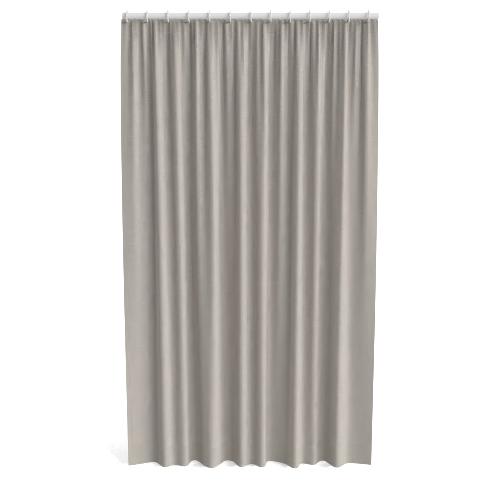

------------------------------------------------------------
추천 71순위 : 시몬 커튼 (화이트)


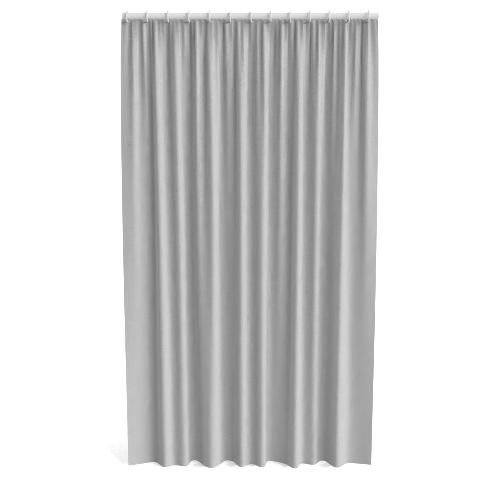

------------------------------------------------------------
추천 81순위 : 시몬 커튼 (그레이)


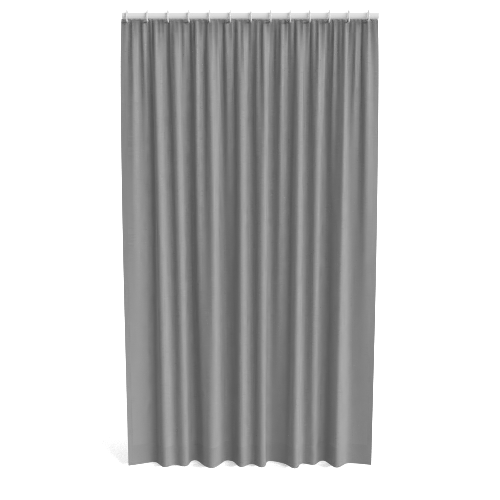

------------------------------------------------------------
추천 91순위 : 아테오 콘센트 2구 화이트


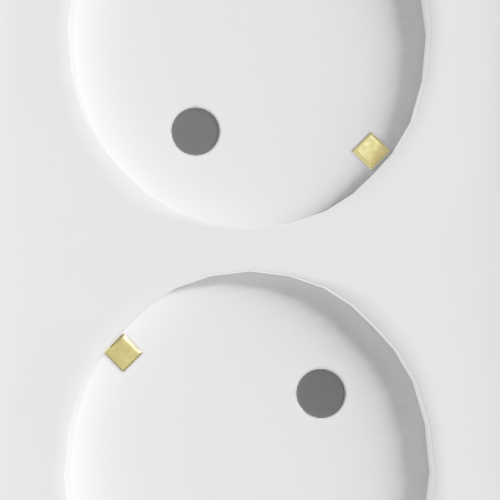

------------------------------------------------------------


In [58]:
prod = "화이트 쉬폰 커튼 화이트"
search_engine_b.search_product(prod, topn=10)

In [59]:
search_engine_b.result

,index,product_id,name,new_tag,projectId,images,similarity
0,13654,18089A2DB64C429F,NEW 린넨스타일 암막커튼 (아이보리),natural mid_century_modern modern 커튼 데코뷰 린넨스타일...,X9XsXFC1E0A0F5CA1394594,[https://resources.archisketch.com/product/180...,0.631579
1,2498,82910C814DDC4712,드레시 화이트 쉬폰+암막커튼 세트 화이트,modern natural bohemian 커튼 데코뷰 드레시 화이트 쉬폰 암막커튼...,X9I1gE5B7E8E8B3C94E4E8D,[https://resources.archisketch.com/product/829...,0.600000
2,6782,9685F6318BD040E1,호텔식 화이트 시폰 커튼,modern natural minimal 커튼 데코뷰 호텔식 화이트 시폰 호텔식 화...,X7Tg_HY6AE26177DEC440D0,[https://resources.archisketch.com/product/968...,0.588235
3,35546,X1-TGzT71248178B7A548B1,시몬 커튼 (묶임) (화이트),modern mid_century_modern natural 데코뷰 시몬 커튼 (묶...,X409w3M81A9EBF4E42F433F,[https://resources.archisketch.com/product/X1-...,0.588235
4,38004,X1-TGzS2B999F3044334858,블랙 쉬폰 나비주름 커튼,modern natural minimal 데코뷰 블랙 쉬폰 나비주름 커튼 x8whc...,X8whcjt93EBB07DA25D429C,[https://resources.archisketch.com/product/X1-...,0.588235
5,13769,X1-TGzS141FF9335F5543F8,화이트 워싱 광목커튼,modern natural scandinavian 데코뷰 화이트 워싱 광목커튼 x8...,X8Q9Pi0B994A39681B347FA,[https://resources.archisketch.com/product/X1-...,0.500000
6,26649,X1-TGzT6F7648A451444525,시몬 커튼 (베이지),natural modern scandinavian 데코뷰 시몬 커튼 (베이지) x9...,X9EhsWH1DE1327FC4954C1B,[https://resources.archisketch.com/product/X1-...,0.500000
7,26648,X1-TGzTFA4D2FCFA7B5472E,시몬 커튼 (화이트),natural modern scandinavian 데코뷰 시몬 커튼 (화이트) x9...,X9EhsWH1DE1327FC4954C1B,[https://resources.archisketch.com/product/X1-...,0.500000
8,38829,X1-TGzT0815232AF3014A85,시몬 커튼 (그레이),modern mid_century_modern vintage 데코뷰 시몬 커튼 (그...,X8lonzK4B12F8EAB4214C23,[https://resources.archisketch.com/product/X1-...,0.500000
9,12052,1FBE282007774E8B,아테오 콘센트 2구 화이트,modern mid_century_modern natural 아테오 콘센트 2구 화...,X9eHrRjE32DBAD155CA45A2,[https://resources.archisketch.com/product/1FB...,0.500000
